If you start seeing a lot of warnings when running the code in this notebook, you may run the cell below to silence them.

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Making Maps

In the last notebook, we found out that we have some coordinates! This notebook will show you how to plot points on a map so you can begin
finding Boreas! 

---

Most of this notebook is informational and full of examples. However, by the end you will know enough to plot all of information in our clue file!

Two commonly used pacakges for plotting in python are [matplotlib](https://matplotlib.org/) (for any kind of data) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) (an extension to matplotlib that allows for nice geographic plots).

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

To start, let's make a plot of the earth and explore some common terms you may need to plot geographic data. The cell below will plot the entire earth using a map [projection](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html) known as the Plate Carree projection.

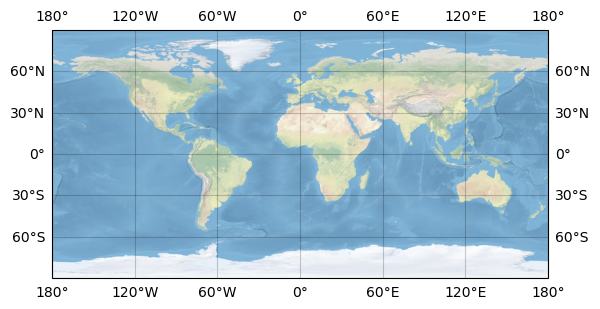

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.gridlines(draw_labels=True, alpha=0.2, color='black')
ax.stock_img()

## Datums

This section is just for extra information; you don't need it for the rest of the tutorial. Please feel free to skip it if you don't care about the intricacies of plotting geographic data.

Suppose your points show up in weird spots on the map. In that case, two usual suspects are at play: either your map's projection isn't right for your data, or your data's datum doesn't match the projection's datum.

What's a [datum](https://en.wikipedia.org/wiki/Geodetic_datum)? It's basically the "reference frame" that defines how the coordinates relate to the real world. Different datums can make the exact latitude and longitude point to slightly different physical places on Earth. So, if your data and map aren't speaking the same "datum language," your points might be in the wrong spot.

By default, Matplotlib and Cartopy assume your data coordinates use the [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System) datum (the standard GPS reference) when plotting geographic data. However, suppose your data is based on a different datum, like [NAD27](https://en.wikipedia.org/wiki/North_American_Datum). Simply plotting it without converting it can cause your points to appear shifted or misplaced.

The example below shows how to explicitly transform coordinates from WGS84 (below this is selected using an [epsg](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) code [4326](https://epsg.io/4326)) to NAD27 (epsg code [4267](https://epsg.io/4267)) using Python's [pyproj library](https://pyproj4.github.io/pyproj/stable/). It then plots both sets of points on the same map using Cartopy's default PlateCarree projection (which assumes WGS84) so you can see the difference in location caused by the datum shift. Even though the latitude and longitude values may look similar, the actual points correspond to slightly different places on Earth.

Don't worry too much about it now; know these two things can cause headaches when plotting locations. 

Difference in degrees: Δlon = -0.00041617, Δlat = -0.00010196


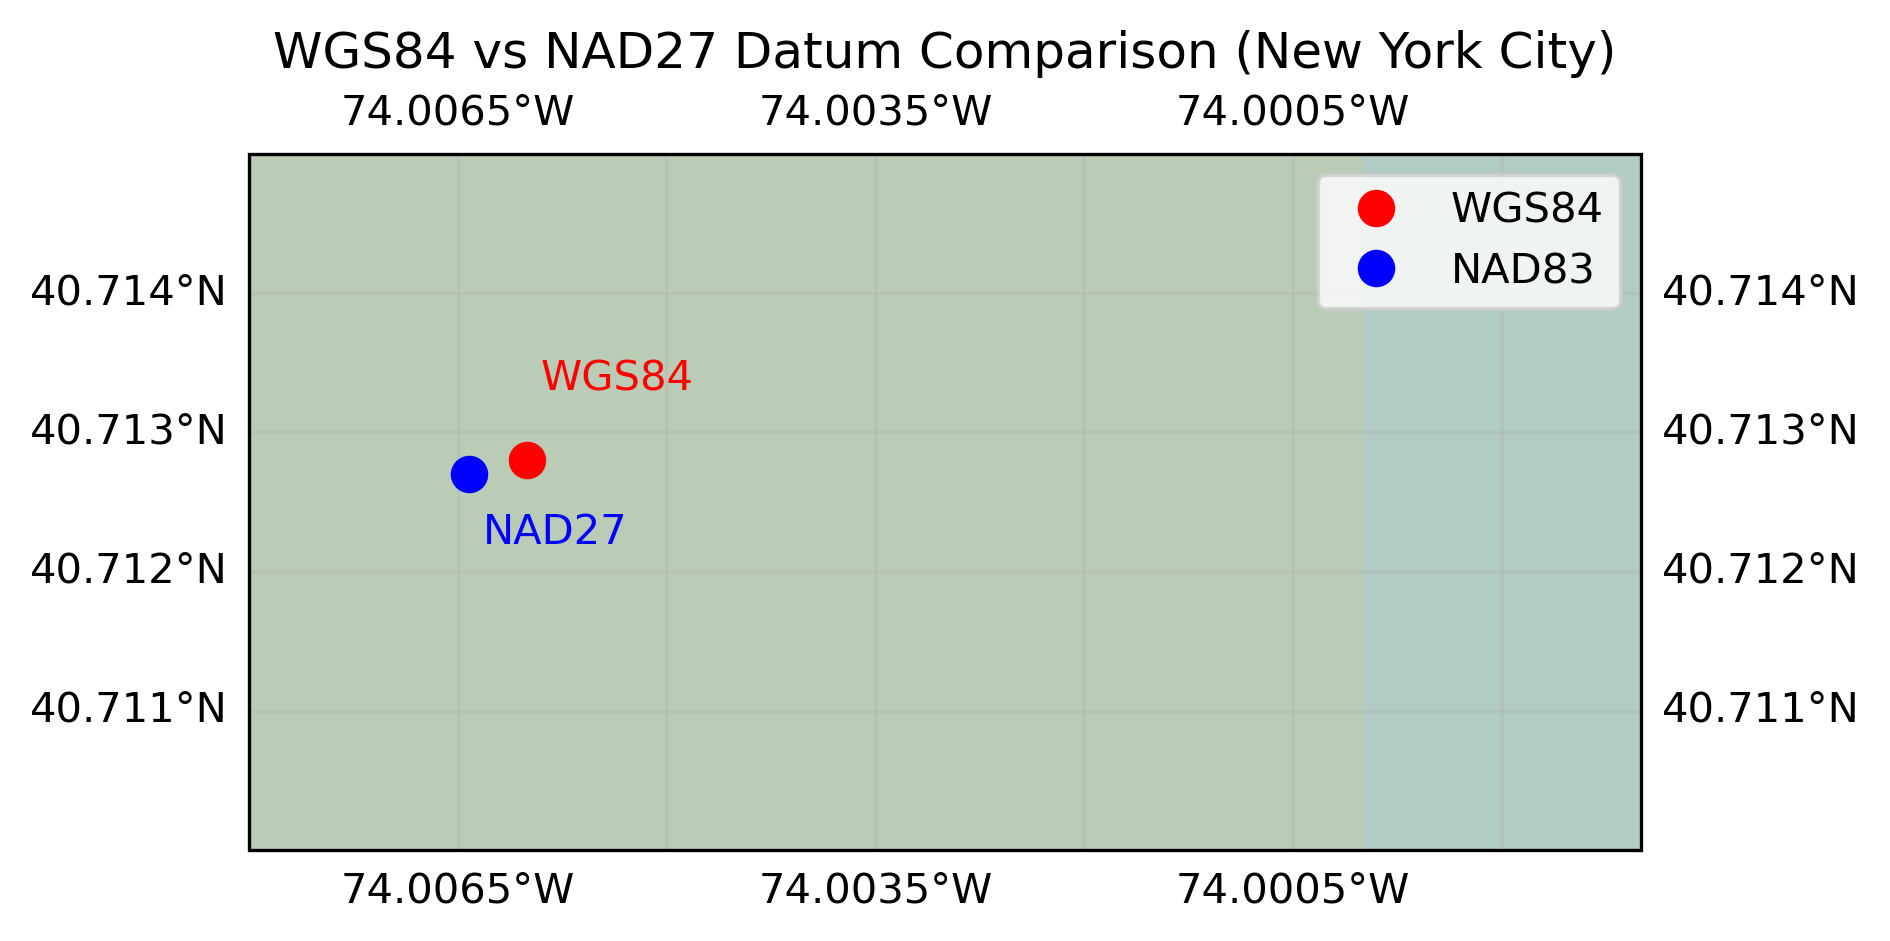

In [21]:
from pyproj import Transformer

# NYC
lon_wgs84, lat_wgs84 = -74.0060, 40.7128

# Transform WGS84 to NAD83
transformer = Transformer.from_crs("EPSG:4326", "EPSG:4267", always_xy=True)
lon_nad83, lat_nad83 = transformer.transform(lon_wgs84, lat_wgs84)

print(f"Difference in degrees: Δlon = {lon_nad83 - lon_wgs84:.8f}, Δlat = {lat_nad83 - lat_wgs84:.8f}")

proj = ccrs.PlateCarree()
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=proj))

ax.set_title("WGS84 vs NAD27 Datum Comparison (New York City)")
ax.stock_img()
ax.coastlines()
ax.gridlines(draw_labels=True, alpha=0.3)

# Plot original WGS84 point
ax.plot(lon_wgs84, lat_wgs84, 'ro', markersize=8, label="WGS84", transform=proj)
ax.text(lon_wgs84 + 0.0001, lat_wgs84 + 0.0005, "WGS84", color='red', transform=proj)

# Plot transformed NAD83 point
ax.plot(lon_nad83, lat_nad83, 'bo', markersize=8, label="NAD83", transform=proj)
ax.text(lon_nad83 + 0.0001, lat_nad83 - 0.0005, "NAD27", color='blue', transform=proj)

# Zoom in to see difference
ax.set_extent([-74.008, -73.998, 40.71, 40.715], crs=proj)

plt.legend()
plt.tight_layout()
plt.show()

## Projections, Web Map Tile Services, Styling

There are many types of projections. All projectons represent the earth in different coordinate systems and can create maps to emphasize different features. The [Plate Caree](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#platecarree) projection is nice because it represents a 2d grid as if all of the latitude and longitudes are equidistant, meaning that one degree in the latitudue or longitude direciton is equal at all points of the earth (which is not true).

A more common projection you may have heard of is the [Robinson](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#robinson) projection. To change a map's projection, simply use a different one in the `subplot_kw` dictionary when making a figure.

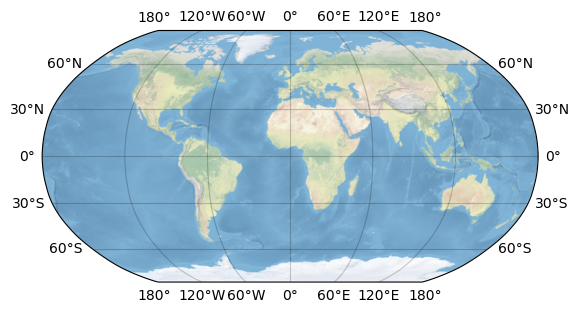

In [27]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson()))

ax.gridlines(draw_labels=True, alpha=0.2, color='black')
ax.stock_img()

Projections can also be centered around a specific area. For example, we will create a map of the United States using a projection that is often used because it gives the contiguous US a shield shape. To do so, we use the [Albers Equal Area](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#albersequalarea) projection, using the center of the United States as its focal point. But this time we will also restrict the bounds to a box which bounds the contiguous US. We will also use some higher resolution basemap features since the default `stock_img` would be too pixelated at this smaller scale. These come installed with cartopy in the [feature](https://scitools.org.uk/cartopy/docs/latest/reference/feature.html) subpackage.

You will also notice that when we set the extent (bounding box) of the map that we add a `PlateCaree()` argument. This is not required here because `PlateCaree` and `AlbersEqualArea` both operate on latitude and longitude values, but some prejections operate on a different set of underlying data values. The second argument to `set_extent` specifies the coordiante reference system of the input arguments and allows cartopy to accurately transform the input data points into the coordinate reference system that the map is plotted on. In general it is good practice to specify the coordinate reference system each time you can so that the base map projection can be changed without updating operations on the map.

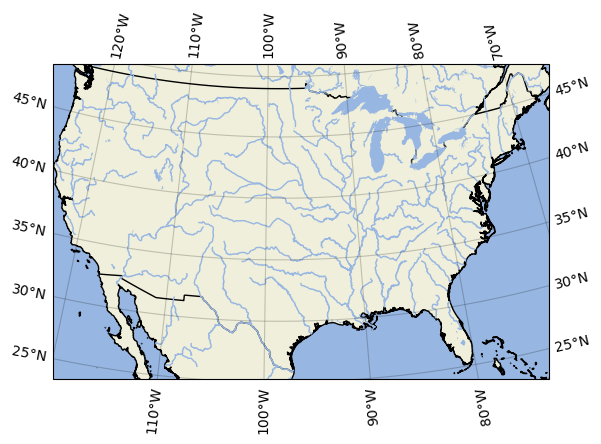

In [13]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)))

minlat = 25
maxlat = 49
minlon = -120
maxlon = -73

ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree())

ax.gridlines(draw_labels=True, alpha=0.2, color='black')

ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'))
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))

That map is a little boring and frankly the colors aren't very fun. We can customize this a bit more to make it more appealing.

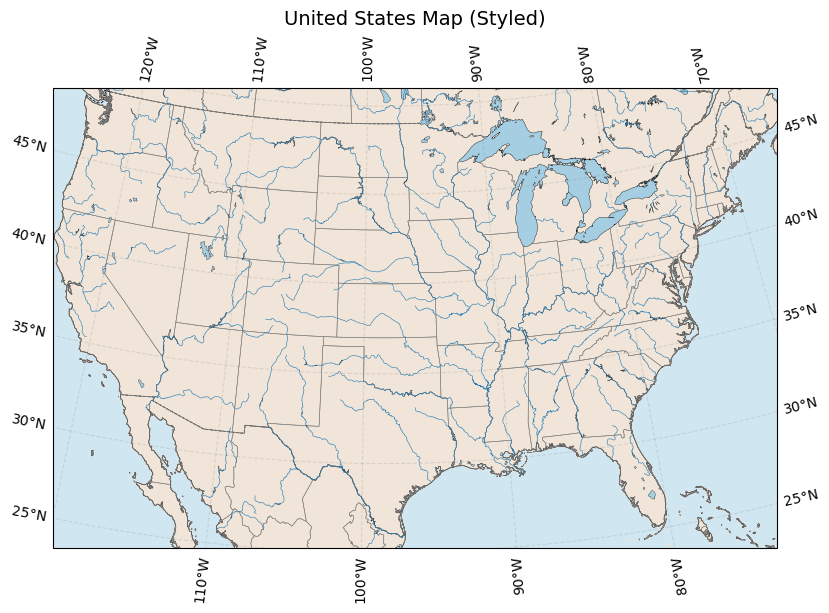

In [15]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(
    projection=ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)))


ax.gridlines(draw_labels=True, alpha=0.2, color='gray', linestyle='--')
ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree())

# Custom styling for the land and ocean features
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor='#f0e5d8')  # soft tan
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                     edgecolor='face',
                                     facecolor='#d0e7f2')  # soft blue

ax.add_feature(ocean, zorder=0)
ax.add_feature(land, zorder=1)

ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', linewidth=0.6)

ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.4, edgecolor='gray')

ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='#a6cee3', edgecolor='k', linewidth=0.2)
ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='#1f78b4', linewidth=0.4)

plt.title("United States Map (Styled)", fontsize=14)
plt.tight_layout()

Well that's cool, but wouldn't it be nice if we could use some real images as the background?

To do so, we can use a [Web Map Tiliing service](https://en.wikipedia.org/wiki/Web_Map_Tile_Service) provided by NASA. We referenced [this example](https://scitools.org.uk/cartopy/docs/latest/gallery/web_services/wmts_time.html#sphx-glr-gallery-web-services-wmts-time-py) to make the image below. 

Below we have chosen to plot September 10, 2020. In this image, we can clearly see the California wildfires that were raging in 2020 at one of the most intense points of the fire.

The cell below may take some time to finish plotting.

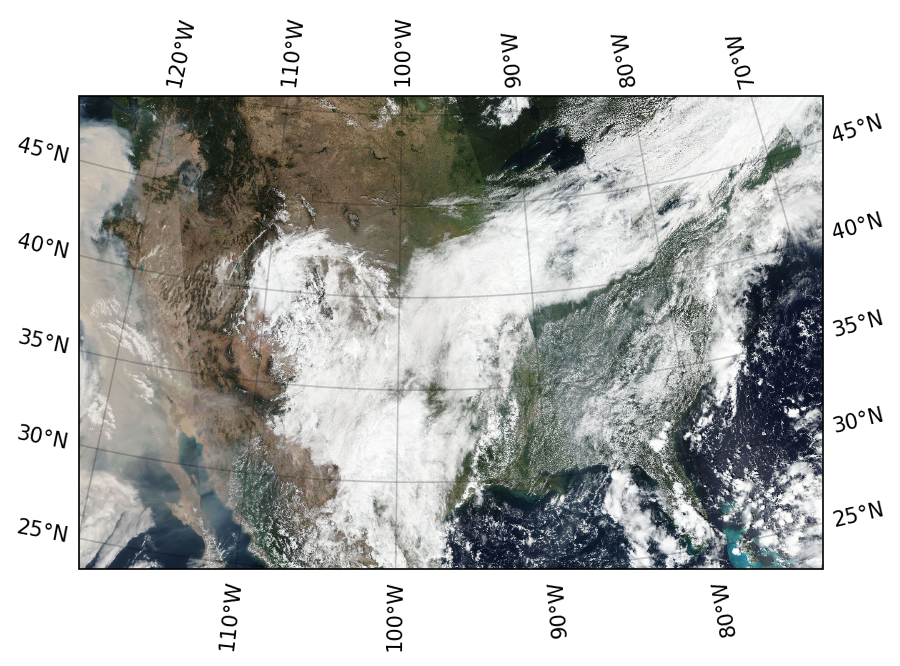

In [36]:
from owslib.wmts import WebMapTileService

plot_crs = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)
fig, ax = plt.subplots(dpi=150, subplot_kw=dict(projection=plot_crs))

url = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts = WebMapTileService(url)

# Layer for VIIRS (Suomi NPP) True Color
layer = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'

date_str = '2020-09-10'

ax.add_wmts(wmts, layer, wmts_kwargs={'time': date_str})

ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree())
ax.gridlines(draw_labels=True, alpha=0.2, color='black')

## Plotting environmental data on a map

In your time at NCAR, you may have the need to plot some geographic data on top of a map. Below is an example of plotting a heat map of temperatore over the US.

We will elide over the finer points of using xarray right now, but a more complete tutorial can be found [here](https://tutorial.xarray.dev/overview/xarray-in-45-min.html).

Below we load an example dataset from xarray that contains air temperature. It's a 3D dataset (lat, lon, time) with one variable, air temperature. Here, we select the first time step and plot its temperature on the map.

Notice that when we plot the air temperature, we have to supply the `transform` argument. This allows cartopy to convert the lat/lon from the temperature dataset from a Plate Caree projection into the Albers Equal Area projection.

We will also plot points on the map. This may help you find Boreas!

In [6]:
data = ds = xr.tutorial.load_dataset("air_temperature")

In [22]:
data

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [35]:
data

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

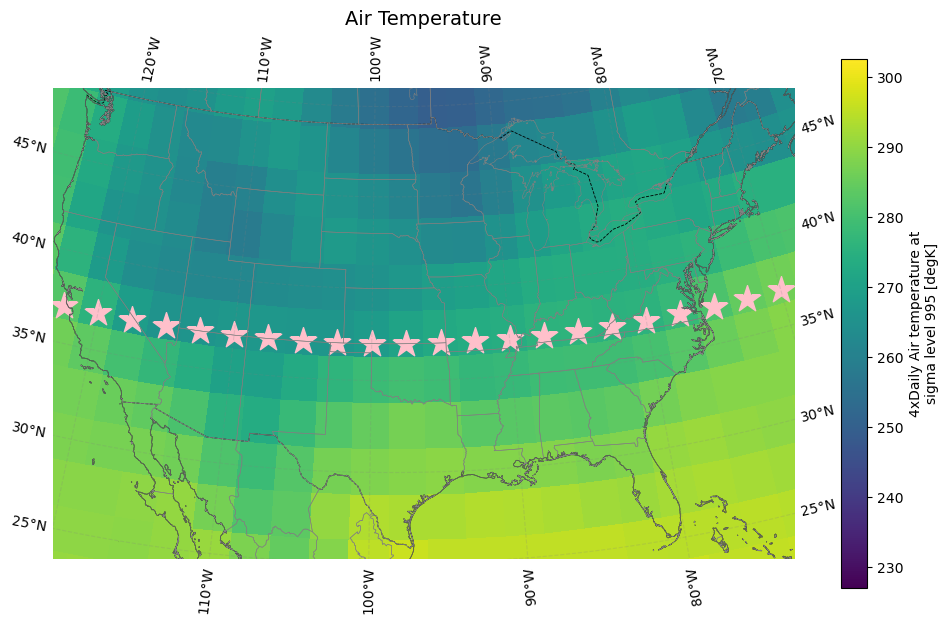

In [67]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(
    projection=ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)))

ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree())
ax.gridlines(draw_labels=True, alpha=0.2, color='gray', linestyle='--')


ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', linewidth=0.6)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.4, edgecolor='gray')

ax.spines[:].set_visible(False)

data.isel(time=0)['air'].plot(ax=ax, transform=ccrs.PlateCarree())

lons = data.lon.values
lats = [(maxlat + minlat) / 2] * len(lons)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='*', color='pink', s=400, edgecolor=None)

plt.title("Air Temperature", fontsize=14)
plt.tight_layout()

# The Clue

Ok, now that we've taken a huge detour from the main mystery with an overview of plotting, let's get back to our investigation!

We will start with plotting the points to see what our data looks like. First, we need to load in the dataset. If you forgot how, 

In [3]:
filename = "boreas_mystery.nc"
with xr.open_dataset(filename) as ds:
    ds.load()

Next you'll want to make a figure choosing some projections you like. To help you choose a bounds, you can get the minimum and maximum of the coordinates

Text(0.5, 1.0, 'Locations: The Mystery of Boreas the Penguin')

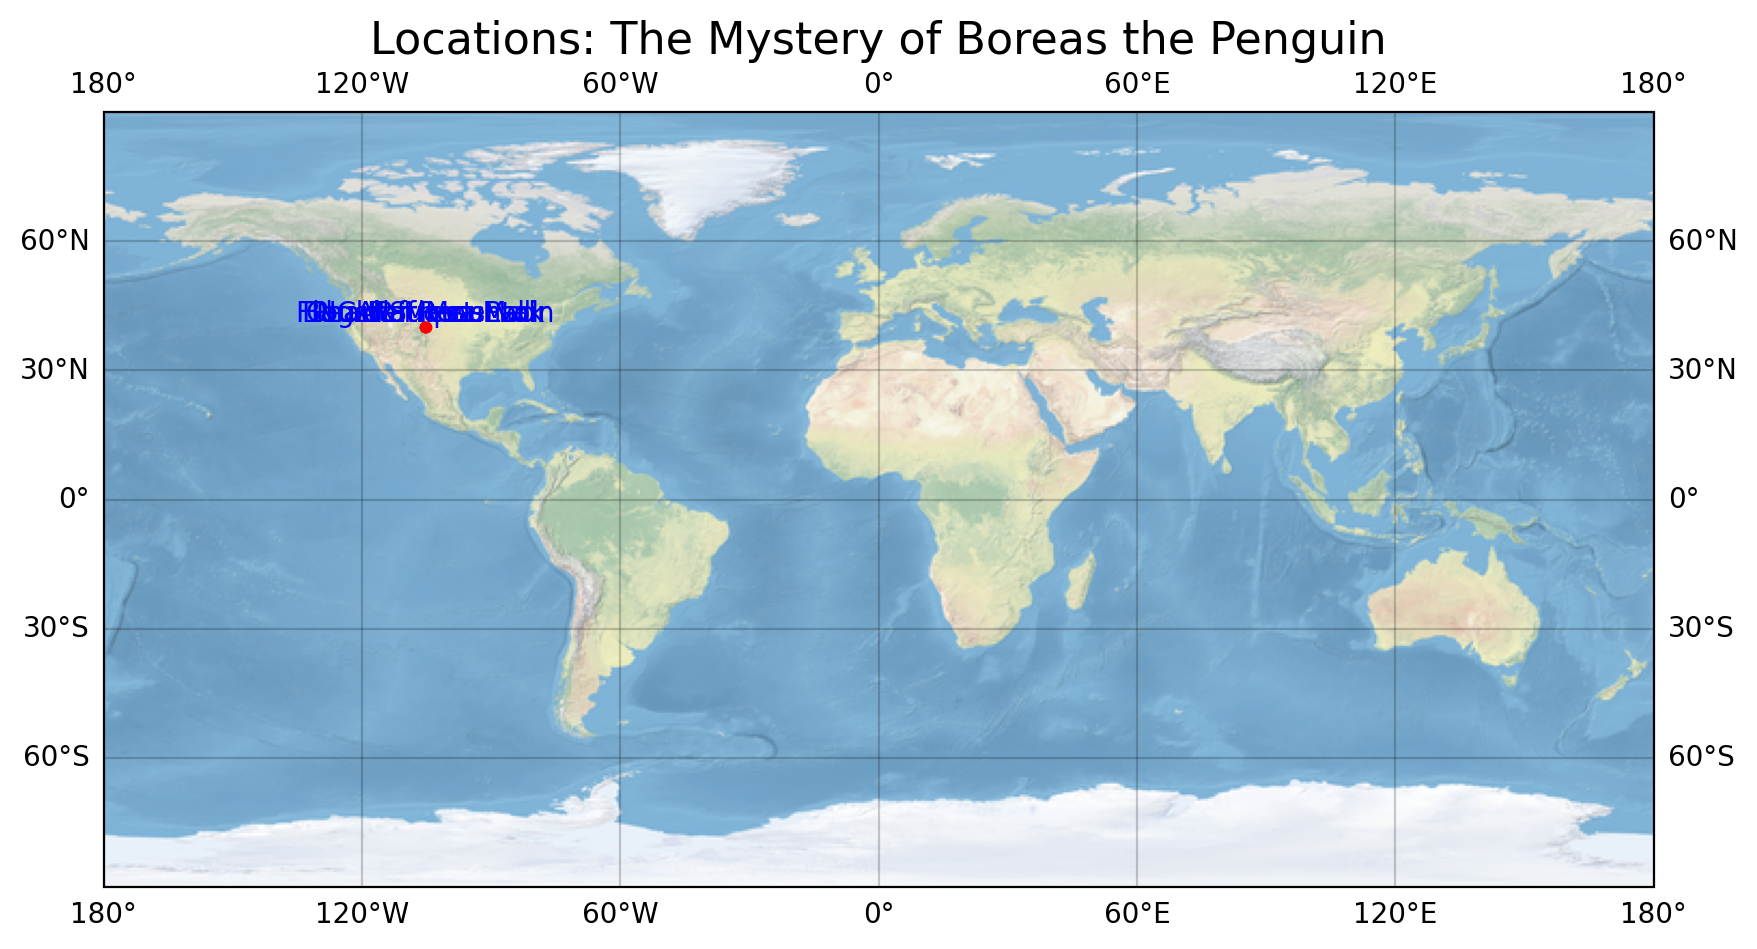

In [38]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200, subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.gridlines(draw_labels=True, alpha=0.2, color='black')
ax.stock_img()

ax.scatter(ds.longitude.values, ds.latitude.values, color='red', s=10, edgecolor=None, transform=ccrs.PlateCarree())

for i, location in enumerate(ds.location_name.values):
    ax.text(ds.longitude.values[i], ds.latitude.values[i], location, color='blue', transform=ccrs.PlateCarree(), ha='center', va='bottom')

plt.title("Locations: The Mystery of Boreas the Penguin", fontsize=16)

Hmmm. All of the data is clustered in the middle of the US. And from the investigation of `ds` above, we think this is likely data in Boulder, Colorado. Let's zoom in on Boulder and plot again.

Text(0.5, 1.0, 'Locations: The Mystery of Boreas the Penguin')

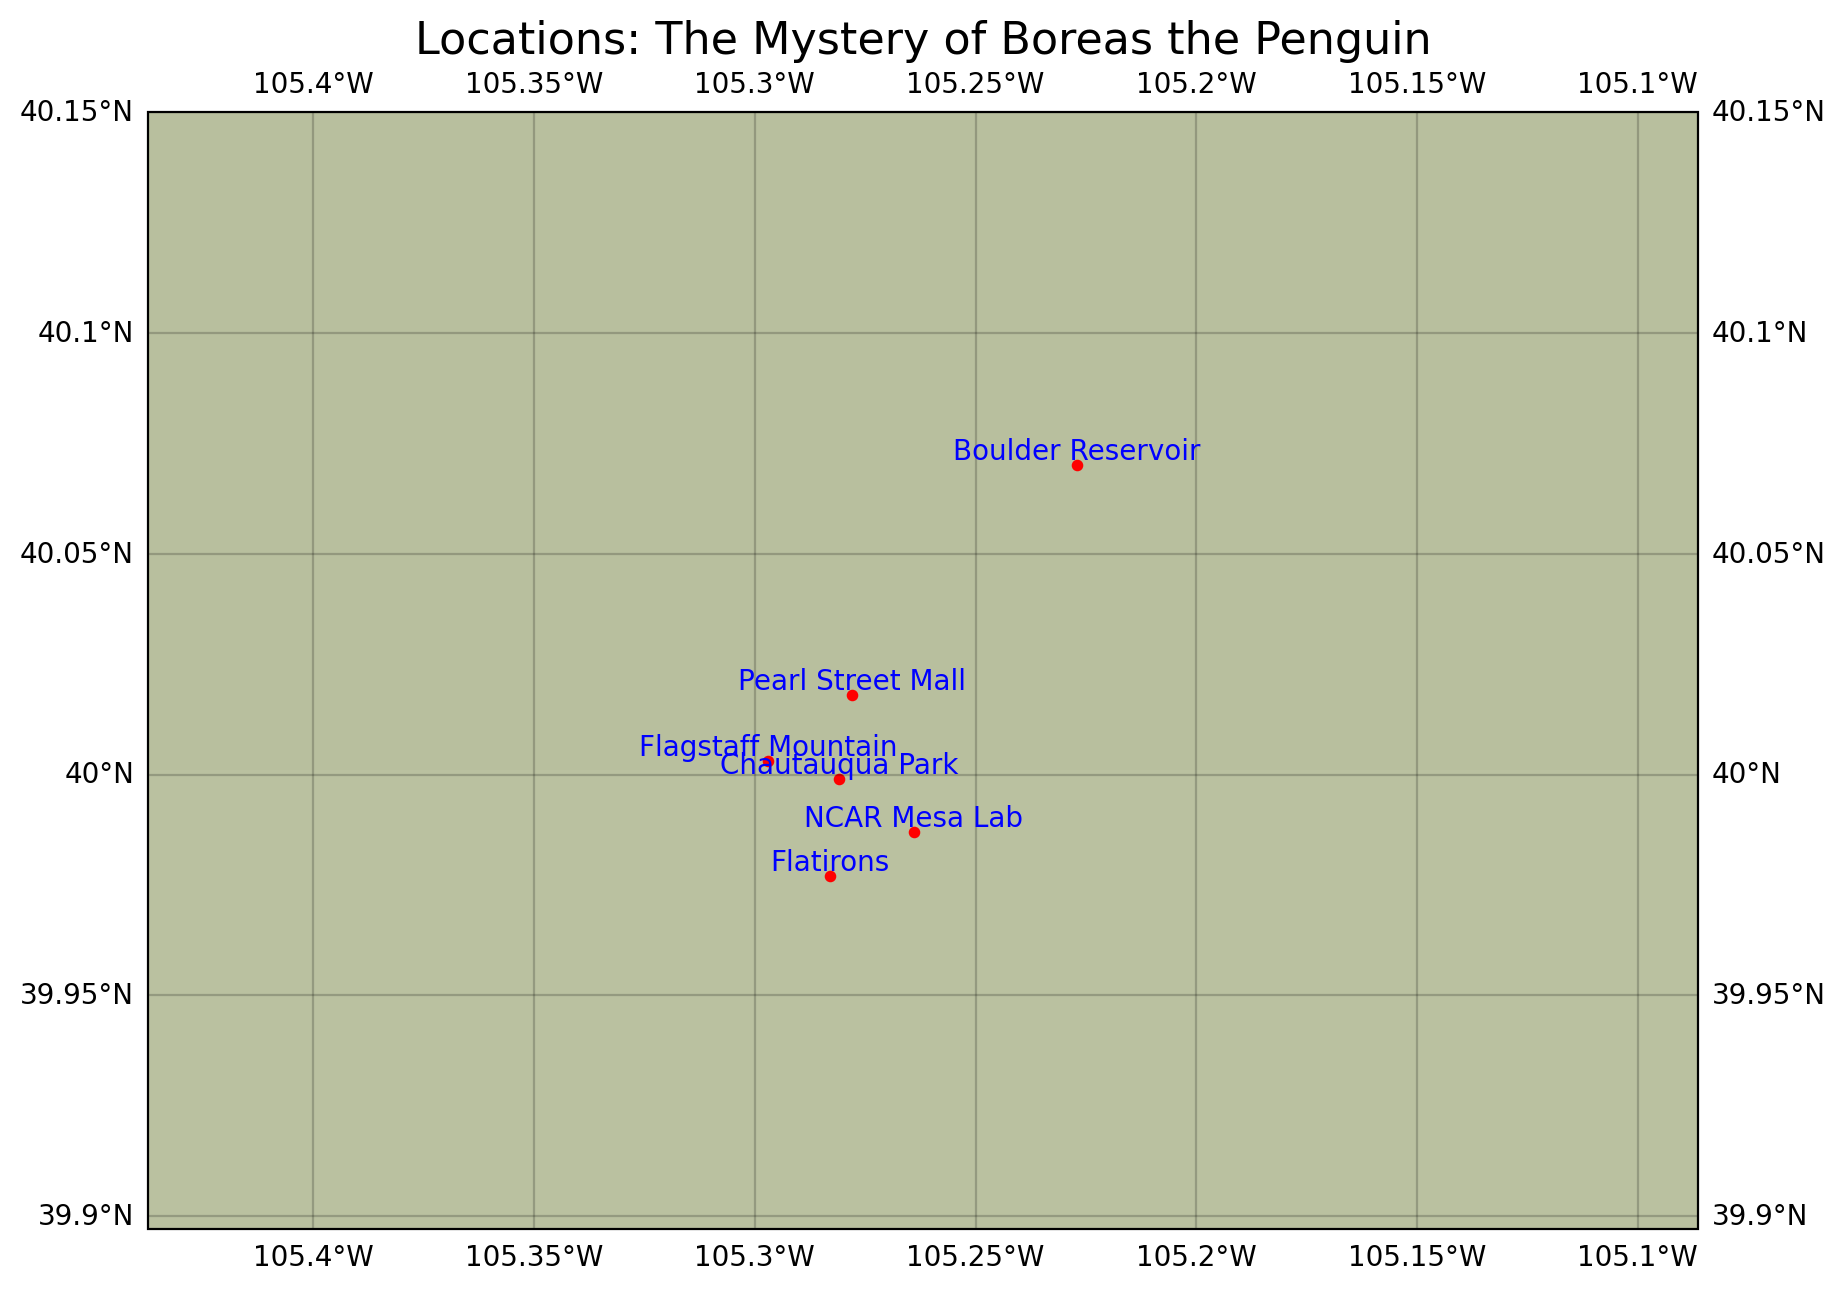

In [39]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200, subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.gridlines(draw_labels=True, alpha=0.2, color='black')
ax.stock_img()

xbuf = .002
ybuf = .002

minlat = ds.latitude.min().item() * (1-ybuf)
maxlat = ds.latitude.max().item() * (1+ybuf)
minlon = ds.longitude.min().item() * (1-xbuf)
maxlon = ds.longitude.max().item() * (1+xbuf)

ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree())

ax.scatter(ds.longitude.values, ds.latitude.values, color='red', s=10, edgecolor=None, transform=ccrs.PlateCarree())

for i, location in enumerate(ds.location_name.values):
    ax.text(ds.longitude.values[i], ds.latitude.values[i], location, color='blue', transform=ccrs.PlateCarree(), ha='center', va='bottom')

plt.title("Locations: The Mystery of Boreas the Penguin", fontsize=16)

And now we see that our basemap has a resolution that is so coarse that there's no detail of the surrouding area at all! Let's use the [Open Street Maps](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.io.img_tiles.OSM.html) tiles.

Text(0.5, 1.0, 'Locations: The Mystery of Boreas the Penguin')

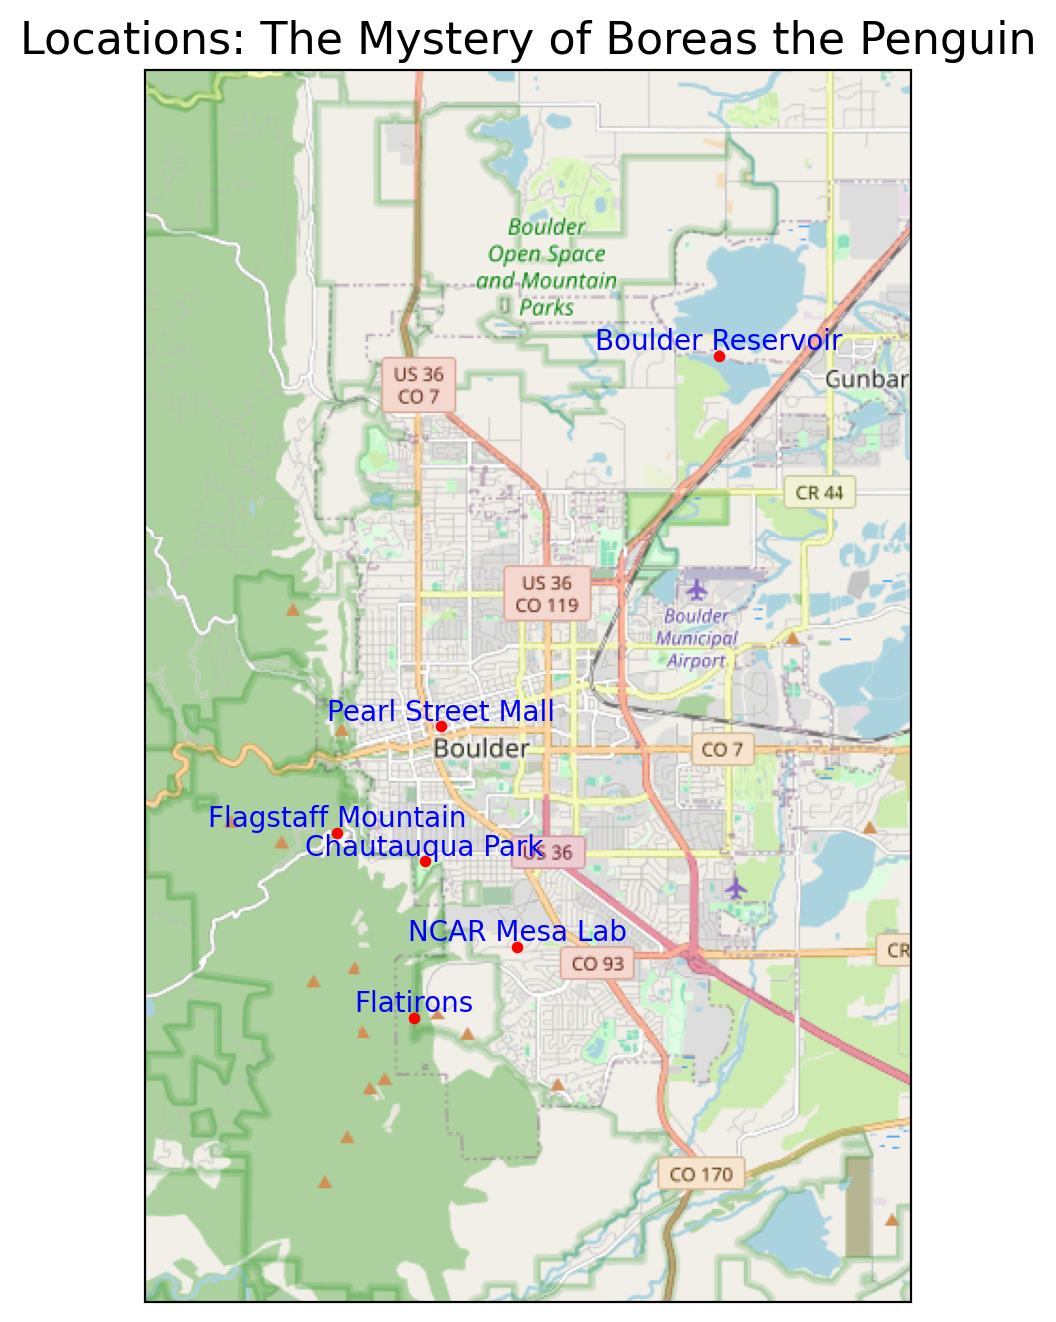

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

tiler = cimgt.OSM() 
mercator = tiler.crs 

fig, ax = plt.subplots(figsize=(10, 8), dpi=200, subplot_kw=dict(projection=mercator))

ax.add_image(tiler, 12)  # 12 is the zoom level; adjust for detail level

xbuf = .001
ybuf = .001

minlat = ds.latitude.min().item() * (1 - ybuf)
maxlat = ds.latitude.max().item() * (1 + ybuf)
minlon = ds.longitude.min().item() * (1 - xbuf)
maxlon = ds.longitude.max().item() * (1 + xbuf)

ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

ax.scatter(ds.longitude.values, ds.latitude.values, color='red', s=10, edgecolor=None, transform=ccrs.PlateCarree())

for i, location in enumerate(ds.location_name.values):
    ax.text(ds.longitude.values[i], ds.latitude.values[i], location, color='blue', transform=ccrs.PlateCarree(), ha='center', va='bottom')

plt.title("Locations: The Mystery of Boreas the Penguin", fontsize=16)